This file includes the training procedure of a classifier as well as a class which can be used to fetch predictions from a string message. An example of how to run the classifier to get predictions can be found at the end of the file.

### Imports and seed

In [1]:
import pickle
import torch.nn as nn
import torchmetrics
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from sklearn.model_selection import GroupShuffleSplit
import sklearn
import time
from collections import defaultdict
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from openai import OpenAI
from pathlib import Path

/home/szolga/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

### Load and prepare chat data

In [3]:
with open("data/190325_data.pkl", "rb") as f:
    chat_data = pickle.load(f)
    
# Remove service chat
del chat_data[-1000]

In [4]:
print(f"Keys for game:\n{chat_data[next(iter(chat_data.keys()))].keys()}\n")
print(f"Keys for message:\n{chat_data[1895]["messages"][0].keys()}")

Keys for game:
dict_keys(['gameID', 'starttime', 'duration', 'botmodel', 'prompt', 'winner', 'createTS', 'updateTS', 'language', 'botname', 'messages', 'player_info'])

Keys for message:
dict_keys(['gameID', 'oldidx', 'color', 'userID', 'botID', 'message', 'create_time', 'colorID', 'messageidx'])


In [5]:
# This filters out games discussing the chat after the game is over
messages = []
labels = []
game_ids = []
for game_id, game_data in chat_data.items():
    for message in game_data["messages"]:
        if message["userID"] == "GameMaster":
            if "won" in message["message"]:
                break
            else:
                continue
        messages.append(message["message"])
        labels.append([int(not message["botID"]), message["botID"]])
        game_ids.append(message["gameID"])
        
print(f"The dataset includes {len(messages)} messages from {len(list(chat_data.keys()))} games")

The dataset includes 22844 messages from 1559 games


In [6]:
# Example message with label
random_nr = random.randint(0, len(messages))
print(f"Message nr: {random_nr}\n")
print(messages[random_nr])
print(f"Message from human" if labels[random_nr][0] == 1 else "Message from bot")
print(f"\nMessage from game with id: {game_ids[random_nr]}")

Message nr: 20952

lasst uns einfach normal kommunizieren, okay?
Message from bot

Message from game with id: 3852


In [ ]:
# If loading of module gives module not found error try manually deleting the cached jina-model and running the code again
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")
#client = OpenAI(
#    api_key="EMPTY",
#    base_url="http://localhost:8000/v1"
#)
#embedding_model = "intfloat/multilingual-e5-large-instruct"

Running on cpu


### Encode data and store to disk for easier use

In [8]:
#then = time.time()
#message_encodings = client.embeddings.create(input = messages, model=embedding_model)
#message_encodings = [message.embedding for message in message_encodings.data]
#print(f"Took {time.time() - then:.2f}s")
#
#with open('data/message_encodings.pkl', 'wb') as f:
#    pickle.dump(message_encodings, f)
#with open('data/labels.pkl', 'wb') as f:
#    pickle.dump(labels, f)

Took 29.44s


In [16]:
with open('data/message_encodings.pkl', 'rb') as f:
    message_encodings = pickle.load(f)
with open('data/labels.pkl', 'rb') as f:
    labels = pickle.load(f)
print("Loaded data")

Loaded data


In [17]:
pca = sklearn.decomposition.PCA(n_components=2)
pca_X = pca.fit_transform(np.asarray(message_encodings))

### Inspect data using PCA and K-Means

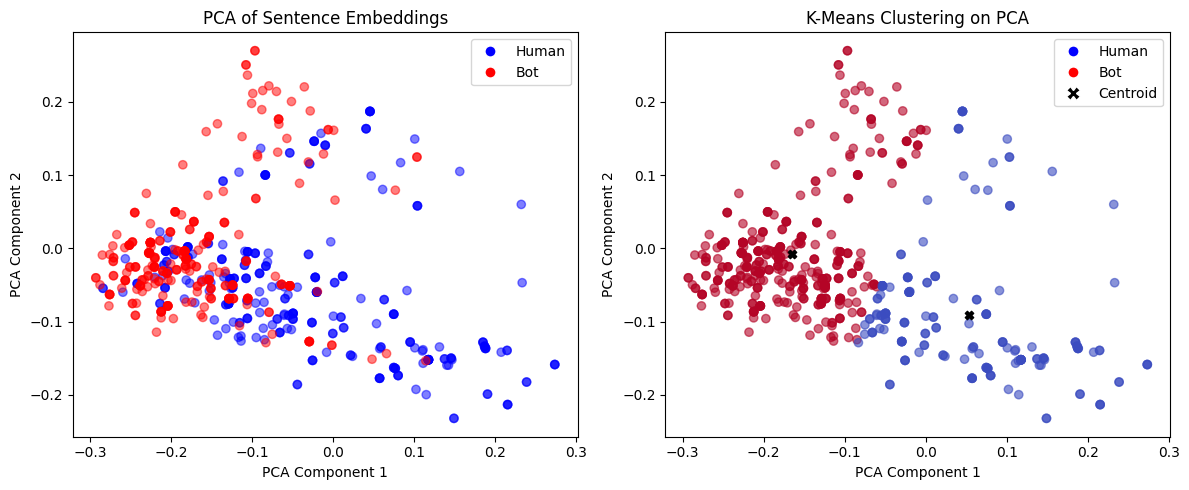

In [18]:
labels = np.array(labels)
n_points_per_class = 300
pca_subset_human = pca_X[np.all(labels == [1, 0], axis=1)]
pca_subset_bot = pca_X[np.all(labels == [0, 1], axis=1)]
random.shuffle(pca_subset_human)
random.shuffle(pca_subset_bot)
pca_points = np.vstack((pca_subset_human[:n_points_per_class], pca_subset_bot[:n_points_per_class]))
pca_labels = np.array([[1, 0]] * n_points_per_class + [[0, 1]] * n_points_per_class)

colors = np.array(["blue", "red"])  
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(pca_points[:, 0], pca_points[:, 1], 
                c=colors[np.array(pca_labels)[:, 1]], alpha=0.5)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Human', markerfacecolor='blue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Bot', markerfacecolor='red', markersize=8)]
axes[0].legend(handles=legend_elements)
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].set_title("PCA of Sentence Embeddings")


kmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(pca_points[:])
axes[1].scatter(pca_points[:, 0], pca_points[:, 1], c=clusters, cmap='coolwarm', alpha=0.6)
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                color='black', marker='X', label='Centroids')
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")
axes[1].set_title("K-Means Clustering on PCA")
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Human', markerfacecolor='blue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Bot', markerfacecolor='red', markersize=8),
                   Line2D([0], [0], marker='X', color='w', label='Centroid', markerfacecolor='black', markersize=10)]

axes[1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()


## Training classifier

In [17]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.33, random_state=42)
train_idx, val_idx = next(gss.split(messages, labels, game_ids))
print(f"Are game_ids of train and test distinct: {set([game_ids[i] for i in train_idx]) & set([game_ids[i] for i in val_idx]) == set()}")

Are game_ids of train and test distinct: True


In [ ]:
X_train, y_train = torch.tensor(np.array([message_encodings[i] for i in train_idx]), dtype=torch.float32), torch.tensor(np.array([labels[i] for i in train_idx]), dtype=torch.float32)
X_val, y_val = torch.tensor(np.array([message_encodings[i] for i in val_idx]), dtype=torch.float32), torch.tensor(np.array([labels[i] for i in val_idx]), dtype=torch.float32)

In [ ]:
train_set = torch.utils.data.TensorDataset(X_train, y_train)
val_set = torch.utils.data.TensorDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

### Knn as baseline

In [ ]:
for k in [2, 5, 10, 15, 20]:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = torchmetrics.Accuracy(num_classes=2, task="binary")
    preds = knn.predict(X_val)
    print(f"Knn accuracy on validation for k={k}: {accuracy(torch.argmax(torch.tensor(preds), dim=1), torch.argmax((y_val), dim=1)):.5f}")

    accuracy = torchmetrics.Accuracy(num_classes=2, task="binary")
    preds = knn.predict(X_train)
    print(f"Knn accuracy on train for k={k}: {accuracy(torch.argmax(torch.tensor(preds), dim=1), torch.argmax((y_train), dim=1)):.5f}")
    print("\n")

Knn accuracy on validation for k=2: 0.83015
Knn accuracy on train for k=2: 0.91367


Knn accuracy on validation for k=5: 0.84246
Knn accuracy on train for k=5: 0.89074


Knn accuracy on validation for k=10: 0.84744
Knn accuracy on train for k=10: 0.87005


Knn accuracy on validation for k=15: 0.84620
Knn accuracy on train for k=15: 0.86301


Knn accuracy on validation for k=20: 0.84481
Knn accuracy on train for k=20: 0.85494




### Multi layer perceptron

In [ ]:
class MessageClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout=0.75):
        super().__init__()
        self.activation = nn.ReLU()
        layers = []
        current_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(torch.nn.Linear(current_size, hidden_size))
            layers.append(torch.nn.BatchNorm1d(hidden_size))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(dropout))
            current_size = hidden_size
        layers.append(torch.nn.Linear(current_size, output_size))

        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    

In [17]:
def evaluate(model, validation_loader, loss_fn, device="cpu"):
    model.eval()
    task="binary"
    accuracy = torchmetrics.Accuracy(num_classes=2, task=task)
    validation_loss = 0
    with torch.no_grad():
        for features, labels in validation_loader:
            output = model(features.to(device))
            accuracy(torch.argmax(output.to("cpu"), dim=1), torch.argmax(labels, dim=1).to("cpu"))
            validation_loss += loss_fn(output.to("cpu"), labels.to("cpu")).item()
    model.train()
    return accuracy.compute(), validation_loss/len(validation_loader)


def train(model, train_loader, optimizer, loss_fn, validation_loader, epochs=30, device="cpu", scheduler=None):
    model.train()
    model.to(device)
    train_acc = []
    train_losses = []
    validation_acc = []
    validation_losses = []
    
    for epoch in tqdm(range(epochs), desc="Epochs"):
        task="binary"
        accuracy = torchmetrics.Accuracy(num_classes=2,task=task)
        train_loss = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            output = model(features.to(device))
            loss = loss_fn(output, labels.to(device))
            loss.backward()
            optimizer.step()
            if isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
                scheduler.step(epoch + i / len(train_loader))
            accuracy(torch.argmax(output.to("cpu"), dim=1), torch.argmax(labels.to("cpu"), dim=1))
            train_loss += loss.item()
            
        val_accuracy, val_loss = evaluate(model, validation_loader, loss_fn, device)
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
                pass
            else:
                scheduler.step()
        train_acc.append(accuracy.compute())
        train_losses.append(train_loss/len(train_loader))
        validation_acc.append(val_accuracy)
        validation_losses.append(val_loss)
    model.eval()
    model.to("cpu")
    return train_acc, validation_acc, train_losses, validation_losses

### Fully connected

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
classifier_0 = MessageClassifier(1024, [48, 24], 2, dropout=0.75)
optimizer = torch.optim.Adam(classifier_0.parameters(), lr=5e-4, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()
train_acc, validation_acc, train_loss, validation_loss = train(classifier_0, train_loader, optimizer, loss_fn, val_loader,
                                                               device=device, epochs=100)

Epochs: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


Text(0.5, 1.0, 'Single message bot prediction')

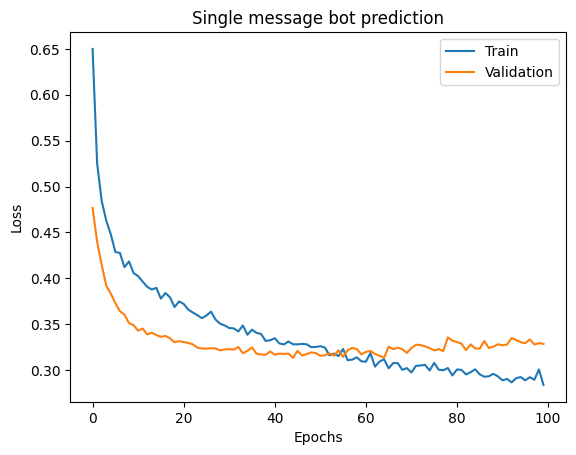

In [19]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.plot(np.arange(len(validation_loss)), validation_loss)
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Single message bot prediction")

Text(0.5, 1.0, 'Single message bot prediction')

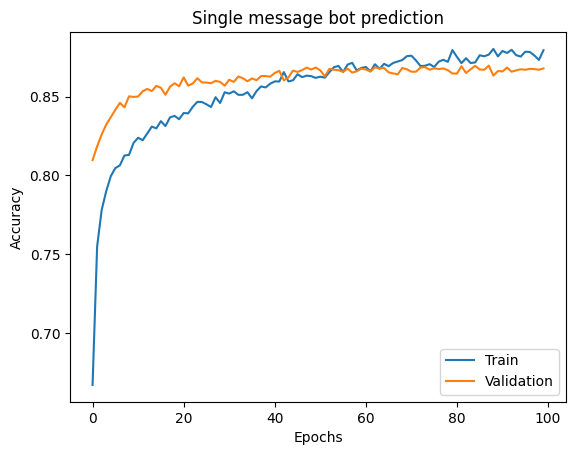

In [20]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.plot(np.arange(len(validation_acc)), validation_acc)
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Single message bot prediction")

In [21]:
print(validation_acc[-1])

tensor(0.8679)


In [24]:
example_nr = 20740
print(example_nr)
print(messages[example_nr])
print(labels[example_nr])
pred = classifier_0(torch.tensor(message_encodings[example_nr]).unsqueeze(0)).squeeze()
print(torch.tanh(pred[1]-pred[0]))

20740
Ich hab kein eigenes Schulsystem, aber ich kenne mich mit vielen aus! Meinst du ein bestimmtes Land oder willst du allgemein wissen, wie verschiedene Schulsysteme funktionieren? 😊
[1 0]
tensor(0.8750, grad_fn=<TanhBackward0>)


In [25]:
torch.save(classifier_0.state_dict(), "trained_models/classifier_state_dict.pth")

In [26]:
classifier_0 = MessageClassifier(1024, [48, 24], 2, dropout=0.75)
classifier_0.load_state_dict(torch.load("trained_models/classifier_state_dict.pth", weights_only=True))
classifier_0.eval()

MessageClassifier(
  (activation): ReLU()
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.75, inplace=False)
    (4): Linear(in_features=48, out_features=24, bias=True)
    (5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.75, inplace=False)
    (8): Linear(in_features=24, out_features=2, bias=True)
  )
)

In [28]:
random_nr = random.randint(0, len(messages))
print(random_nr)
print(messages[random_nr])
print(labels[random_nr])
pred = classifier_0(torch.tensor(message_encodings[random_nr]).unsqueeze(0)).squeeze()
print(torch.tanh(pred[1]-pred[0]))

3668
yellow, woher kommst du?
[1 0]
tensor(-0.9986, grad_fn=<TanhBackward0>)


## Evaluation of the Classifier on old games

In [18]:
class Classifier:
    def __init__(self, path_to_state_dict):
        class MessageClassifier(nn.Module):
            def __init__(self, input_size, hidden_sizes, output_size, dropout=0.75):
                super().__init__()
                self.activation = nn.ReLU()
                layers = []
                current_size = input_size
                for hidden_size in hidden_sizes:
                    layers.append(torch.nn.Linear(current_size, hidden_size))
                    layers.append(torch.nn.BatchNorm1d(hidden_size))
                    layers.append(torch.nn.ReLU())
                    layers.append(torch.nn.Dropout(dropout))
                    current_size = hidden_size
                layers.append(torch.nn.Linear(current_size, output_size))
        
                self.model = torch.nn.Sequential(*layers)
        
            def forward(self, x):
                return self.model(x)

        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.client = OpenAI(
                            api_key="EMPTY",
                            base_url="http://localhost:8000/v1"
                        )
        self.embedding_model = "intfloat/multilingual-e5-large-instruct"

        self.classifier = MessageClassifier(1024, [48, 24], 2, dropout=0.75)
        self.classifier.to(self.device)
        self.classifier.load_state_dict(torch.load(path_to_state_dict, weights_only=True))
        self.classifier.eval()

    def predict(self, message: str):
        # Classifies a message as human (negative score) or bot (positive score).
        embedding = torch.tensor(self.client.embeddings.create(input = [message], model=self.embedding_model).data[0].embedding)
        pred = self.classifier(embedding.unsqueeze(dim=0)).squeeze()
        return torch.tanh(pred[1]-pred[0]).item()

In [19]:
classifier = Classifier("trained_models/classifier_state_dict.pth")

In [20]:
def evaluate_on_old_games(classifier, threshold=1):
    with open("data/190325_data.pkl", "rb") as f:
        chat_data = pickle.load(f)
    
    val_games = set([game_ids[i] for i in val_idx])

    true_positives = 0
    false_positives = 0
    true_negative = 0
    false_negative = 0



    for game_id in tqdm(val_games, desc="Evaluating", total=len(val_games)):
        # Retrieve game
        game = chat_data[game_id]
        player_scores = defaultdict(float)
        # Calculate Scores
        for message in game["messages"]:
            if message["userID"] == "GameMaster":
                if "won" in message["message"]:
                    break
                else:
                    continue
            else:
                if message["botID"]:
                    player_scores["bot"] += classifier.predict(message["message"])
                else:
                    player_scores[message["color"]] += classifier.predict(message["message"])

        # Check scores
        colors = list(player_scores.keys())
        for color1 in colors:
            for color2 in colors:
                if color1 != "bot" and color2 != "bot": # Only check pairs that include a bot
                    continue
                if player_scores[color1] - player_scores[color2] > threshold:
                    # This is a positive classification
                    if color1 == "bot":
                        true_positives += 1
                    else:
                        false_positives += 1
                else:
                    # This is a negative classification
                    if color1 == "bot":
                        false_negative += 1
                    else:
                        true_negative += 1
    return true_positives, false_positives, true_negative, false_negative

In [32]:
threshold = 1
TP, FP, TN, FN = evaluate_on_old_games(classifier, threshold=threshold)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)
accuracy = (TP+TN)/(TP+FN+TN+FP)

print(f"Data is for threshold: {threshold}")
print(f"True positives: {TP}")
print(f"False positives: {FP}")
print(f"True negatives: {TN}")
print(f"False negatives: {FN}")
print(f"Precision: {round(precision*100, 2)}")
print(f"Recall: {round(recall*100, 2)}")
print(f"F1: {round(f1*100, 2)}")
print(f"Accuracy: {round(accuracy*100, 2)}")

Evaluating: 100%|██████████| 417/417 [09:17<00:00,  1.34s/it]

Data is for threshold: 1
True positives: 683
False positives: 4
True negatives: 710
False negatives: 414
Precision: 99.42
Recall: 62.26
F1: 76.57
Accuracy: 76.92


In [33]:
threshold = 3
TP, FP, TN, FN = evaluate_on_old_games(classifier, threshold=threshold)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)
accuracy = (TP+TN)/(TP+FN+TN+FP)

print(f"Threshold: {threshold}")
print(f"True positives: {TP}")
print(f"False positives: {FP}")
print(f"True negatives: {TN}")
print(f"False negatives: {FN}")
print(f"Precision: {round(precision*100, 2)}")
print(f"Recall: {round(recall*100, 2)}")
print(f"F1: {round(f1*100, 2)}")
print(f"Accuracy: {round(accuracy*100, 2)}")

Evaluating: 100%|██████████| 417/417 [09:14<00:00,  1.33s/it]

Threshold: 3
True positives: 588
False positives: 0
True negatives: 714
False negatives: 509
Precision: 100.0
Recall: 53.6
F1: 69.79
Accuracy: 71.89


# Apply classifier

Don't forget your imports when using this code somewhere else

In [24]:
class Classifier:
    def __init__(self, path_to_state_dict):
        class MessageClassifier(nn.Module):
            def __init__(self, input_size, hidden_sizes, output_size, dropout=0.75):
                super().__init__()
                self.activation = nn.ReLU()
                layers = []
                current_size = input_size
                for hidden_size in hidden_sizes:
                    layers.append(torch.nn.Linear(current_size, hidden_size))
                    layers.append(torch.nn.BatchNorm1d(hidden_size))
                    layers.append(torch.nn.ReLU())
                    layers.append(torch.nn.Dropout(dropout))
                    current_size = hidden_size
                layers.append(torch.nn.Linear(current_size, output_size))
        
                self.model = torch.nn.Sequential(*layers)
        
            def forward(self, x):
                return self.model(x)

        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.client = OpenAI(
                            api_key="EMPTY",
                            base_url="http://localhost:8000/v1"
                        )
        self.embedding_model = "intfloat/multilingual-e5-large-instruct"

        self.classifier = MessageClassifier(1024, [48, 24], 2, dropout=0.75)
        self.classifier.to(self.device)
        self.classifier.load_state_dict(torch.load(path_to_state_dict, weights_only=True))
        self.classifier.eval()

    def predict(self, message: str):
        # Classifies a message as human (negative score) or bot (positive score).
        embedding = torch.tensor(self.client.embeddings.create(input = [message], model=self.embedding_model).data[0].embedding)
        pred = self.classifier(embedding.unsqueeze(dim=0)).squeeze()
        return torch.tanh(pred[1]-pred[0]).item()

In [25]:
classifier = Classifier("trained_models/classifier_state_dict.pth")

In [26]:
classifier.predict("yeah ik, how are you?")

-0.9355129599571228